# Module 2 Project

### The Project

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company.

# Questions
**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**
<br>
**Null Hypothesis:** The difference between the mean quantities of products sold at each discount level and the mean quantity of products sold without a discount is zero.
<br>
**Alternative Hypothesis:** The difference between the mean quantities of products sold at each discount level and the mean quantity of products sold without a discount differs from zero.<br><br>
**_Do salespeople have a statistically significant effect on the number of products customers order? If so, who are the top/bottom performers?_**
<br>
**Null Hypothesis:** The difference between the mean quantities products sold by each salesperson and the mean quantity of products sold across the rest of the firm is zero.
<br>
**Alternative Hypothesis:** The difference between the mean quantities products sold by each salesperson and the mean quantity of products sold by the rest of the firm differs from zero.<br><br>
**_Does customer region have a statistically significant impact on the number of products ordered? If so, which regions order the most products on a per order basis?_**
<br>
**Null Hypothesis:** The difference between the mean quantities products sold to each region and the mean quantity of products sold across all regions is zero.
<br>
**Alternative Hypothesis:** The difference between the mean quantities products sold to each region and the mean quantity of products sold to all regions differs from zero.<br><br>
**_Does product category have a statistically significant impact on the number of products ordered? If so, which categories result in the highest volume per order?_**
<br>
**Null Hypothesis:** The difference between the mean quantities products sold in each category and the mean quantity of products sold across all categories is zero.
<br>
**Alternative Hypothesis:** The difference between the mean quantities products sold in each category and the mean quantity of products sold across all categories differs from zero.<br><br>
All tests will be two-tail tests due to the face that we are interested in knowing if any factors above result in reduced quantities of product sold, as well as increases.

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import *
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-03-25 17:42:52,018 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-25 17:42:52,019 INFO sqlalchemy.engine.base.Engine ()
2019-03-25 17:42:52,020 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-25 17:42:52,021 INFO sqlalchemy.engine.base.Engine ()


In [3]:
inspector = inspect(engine)

list(inspector.get_table_names())

2019-03-25 17:42:52,027 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-03-25 17:42:52,027 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print(f'Table Name: {col_name}\n')
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

for table in inspector.get_table_names():
    get_columns_info(table)
    print('\n')

2019-03-25 17:42:52,040 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-03-25 17:42:52,040 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)


2019-03-25 17:42:52,044 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-03-25 17:42:52,045 INFO sqlalchemy.engine.base.Engine ()
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)


2019-03-25 17:42:52,048 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-03-25 17:42:52,049 INFO sqlalchemy.engine

In [5]:
pd.read_sql_query('''SELECT * FROM [OrderDetail]''', engine).shape

2019-03-25 17:42:52,102 INFO sqlalchemy.engine.base.Engine SELECT * FROM [OrderDetail]
2019-03-25 17:42:52,103 INFO sqlalchemy.engine.base.Engine ()


(2155, 6)

In [6]:
df = pd.read_sql_query('''SELECT od.*, 
                       o.CustomerId, o.EmployeeId, 
                       e.LastName AS EmpLastName,
                       c.Region,
                       p.CategoryId,
                       cat.CategoryName
                       
                       FROM OrderDetail od
                       JOIN [Order] o
                       ON od.OrderId = o.Id
                       
                       JOIN Employee e
                       ON o.EmployeeId = e.Id
                       
                       JOIN Customer c
                       ON o.CustomerId = c.Id
                       
                       JOIN Product p
                       ON od.ProductId = p.Id
                       
                       JOIN Category cat
                       ON p.CategoryId = cat.Id;''', engine)
df.head()

2019-03-25 17:42:52,138 INFO sqlalchemy.engine.base.Engine SELECT od.*, 
                       o.CustomerId, o.EmployeeId, 
                       e.LastName AS EmpLastName,
                       c.Region,
                       p.CategoryId,
                       cat.CategoryName
                       
                       FROM OrderDetail od
                       JOIN [Order] o
                       ON od.OrderId = o.Id
                       
                       JOIN Employee e
                       ON o.EmployeeId = e.Id
                       
                       JOIN Customer c
                       ON o.CustomerId = c.Id
                       
                       JOIN Product p
                       ON od.ProductId = p.Id
                       
                       JOIN Category cat
                       ON p.CategoryId = cat.Id;
2019-03-25 17:42:52,139 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,EmpLastName,Region,CategoryId,CategoryName
0,10248/11,10248,11,14.0,12,0.0,VINET,5,Buchanan,Western Europe,4,Dairy Products
1,10248/42,10248,42,9.8,10,0.0,VINET,5,Buchanan,Western Europe,5,Grains/Cereals
2,10248/72,10248,72,34.8,5,0.0,VINET,5,Buchanan,Western Europe,4,Dairy Products
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,Suyama,Western Europe,7,Produce
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,Suyama,Western Europe,7,Produce


In [7]:
df['Employee'] = df['EmpLastName'] + df['EmployeeId'].astype('str')
df = df.drop(['EmployeeId', 'EmpLastName', 'Id', 'ProductId', 'CategoryId'], axis=1)
df.head()

,OrderId,UnitPrice,Quantity,Discount,CustomerId,Region,CategoryName,Employee
0,10248,14.0,12,0.0,VINET,Western Europe,Dairy Products,Buchanan5
1,10248,9.8,10,0.0,VINET,Western Europe,Grains/Cereals,Buchanan5
2,10248,34.8,5,0.0,VINET,Western Europe,Dairy Products,Buchanan5
3,10249,18.6,9,0.0,TOMSP,Western Europe,Produce,Suyama6
4,10249,42.4,40,0.0,TOMSP,Western Europe,Produce,Suyama6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 8 columns):
OrderId         2078 non-null int64
UnitPrice       2078 non-null float64
Quantity        2078 non-null int64
Discount        2078 non-null float64
CustomerId      2078 non-null object
Region          2078 non-null object
CategoryName    2078 non-null object
Employee        2078 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 130.0+ KB


In [9]:
df.describe()

,OrderId,UnitPrice,Quantity,Discount
count,2078.000000,2078.000000,2078.000000,2078.000000
mean,10658.376323,26.277416,23.924447,0.056035
std,242.371015,29.962501,19.151339,0.083421
min,10248.000000,2.000000,1.000000,0.000000
25%,10449.000000,12.000000,10.000000,0.000000
50%,10656.000000,18.400000,20.000000,0.000000
75%,10861.000000,32.000000,30.000000,0.100000
max,11077.000000,263.500000,130.000000,0.250000


In [10]:
formula = 'Quantity ~ Discount + C(Employee) + C(Region) + C(CategoryName)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq      df          F        PR(>F)
C(Employee)        8259.303411     8.0   3.010143  2.313174e-03
C(Region)         40031.874384     8.0  14.589809  6.642581e-21
C(CategoryName)     959.751343     7.0   0.399755  9.028854e-01
Discount           6925.520310     1.0  20.192314  7.392950e-06
Residual         704133.930739  2053.0        NaN           NaN


After performing an ANOVA test, we can see that the product category does not have a statistically significant impact on the quantity of products sold at the 95% confidence level. 

<br>The region has the largest impact on quantity sold, followed by discount level and employee.

In [11]:
def dist_plot(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Create a distribution plot to compare control and test groups for hypothesis testing
    plt.figure(figsize=(8, 8))
    sns.distplot(control, color='red', label=ctrl_label)
    sns.distplot(test, color='blue', label=test_label)
    plt.legend()
    plt.show()

In [12]:
from __future__ import print_function, division
import scipy.stats

def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
       output : x and y values for the normal distribution
       '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

In [13]:
def norm_dist(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Evaluate the PDF's of control and test groups and generate normal distributions to visualize the mean and variance differences
    control_mean, control_std = np.mean(control), np.std(control)
    control_quant = scipy.stats.norm(control_mean, control_std)

    test_mean, test_std = np.mean(test), np.std(test)
    test_quant = scipy.stats.norm(test_mean, test_std)
    
    plt.figure(figsize=(8, 8))

    xs, ys = evaluate_PDF(control_quant)
    plt.plot(xs, ys, label=ctrl_label, linewidth=4, color='red')
    plt.axvline(x=control_mean, color='red', ls='-.', label=f'{ctrl_label} Mean: {np.round(control_mean, 2)}')

    xs, ys = evaluate_PDF(test_quant)
    plt.plot(xs, ys, label=test_label, linewidth=4, color='blue') 
    plt.axvline(x=test_mean, color='blue', ls='-.', label=f'{test_label} Mean: {np.round(test_mean, 2)}')

    plt.xlabel('Quantity')
    plt.legend()
    plt.show()


In [14]:
def test_results(control, test):
    return stats.ttest_ind(test, control)

In [15]:
def get_results(control, test, ctrl_label='Control Label', test_label='Test Label', conf_lvl = .95):
    # Determine if the mean differences between control and test groups are statistically significant
    # If so, display results & distribution plots, evaluate the PDF's, and provide normal distribution visualizations
    
    ctrl_mean, ctrl_std = np.mean(control), np.std(control)
    test_mean, test_std = np.mean(test), np.std(test)
    
    mean_diff = (test_mean - ctrl_mean) / ctrl_mean
    std_diff = (test_std - ctrl_std) / ctrl_std
    
#   Treating standard deviation as a measure of risk and mean as a measure of return,
#   the risk adjusted return represents the results as a function of risk.
#   If the difference between the standard deviation of the test and control groups exceeds the
#   difference between the respective means, the risk adjusted return will be negative.
#   If the opposite is true, the risk adjusted return will be positive.
    risk_adj_rtn = (1 + mean_diff) / (1 + std_diff) - 1
    
    t_stat, p_val = test_results(control, test)
#   Print all key metrics for the test group if results are statistically significant, along with relevant plots.
#   Otherwise, indicate that the results are not significant at the given confidence level.
    print(f'Key Metrics for {test_label}')    
    if p_val < (1-conf_lvl):
        print(f'  {ctrl_label} Mean: {np.round(ctrl_mean, 2)}')
        print(f'  {test_label} Mean: {np.round(test_mean, 2)}')
        print(f'  Percent Mean Difference: {np.round(100 * mean_diff, 2)}%\n')
        print(f'  {ctrl_label} Std Dev: {np.round(ctrl_std, 2)}')
        print(f'  {test_label} Std Dev: {np.round(test_std, 2)}')
        print(f'  Percent Std Dev Difference: {np.round(100 * std_diff, 2)}%')
        print(f'  Risk Adjusted Return {test_label}: {np.round(100 * risk_adj_rtn, 2)}%\n')
        print(f'  Test Statistic: {np.round(t_stat, 4)}')
        print(f'  P-Value: {np.round(p_val, 6)}')
        dist_plot(control, test, ctrl_label=ctrl_label, test_label=test_label)
        norm_dist(control, test, ctrl_label=ctrl_label, test_label=test_label)
    else:
        print(f'{test_label} Not Significant at {np.round(100*conf_lvl, 2)}% Confidence Level\n')
        
#   Regardless of significance, return the key statistics to a dictionary for evaluation.
    keys = ['Ctrl Mean', 'Ctrl Std', 'Test Mean', 'Test Std', 'Mean Diff', 'Std Diff', 'Risk Adj Rtn', 't-stat', 'p_val']   
    values = [ctrl_mean, ctrl_std, test_mean, test_std, mean_diff, std_diff, risk_adj_rtn, t_stat, p_val]
    return dict(zip(keys, values))

In [16]:
regions = df['Region'].unique()
regions, np.mean(df['Region'].value_counts())

(array(['Western Europe', 'South America', 'Central America',
        'North America', 'Northern Europe', 'Scandinavia',
        'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object),
 230.88888888888889)

Key Metrics for Western Europe
  All Other Regions Mean: 23.05
  Western Europe Mean: 27.47
  Percent Mean Difference: 19.17%

  All Other Regions Std Dev: 18.05
  Western Europe Std Dev: 20.96
  Percent Std Dev Difference: 16.1%
  Risk Adjusted Return Western Europe: 2.65%

  Test Statistic: 2.8836
  P-Value: 0.004019


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


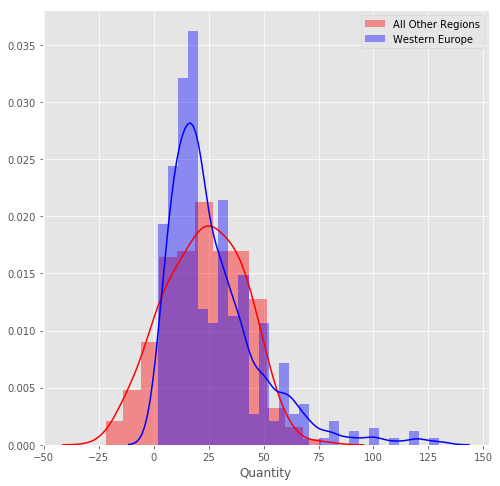

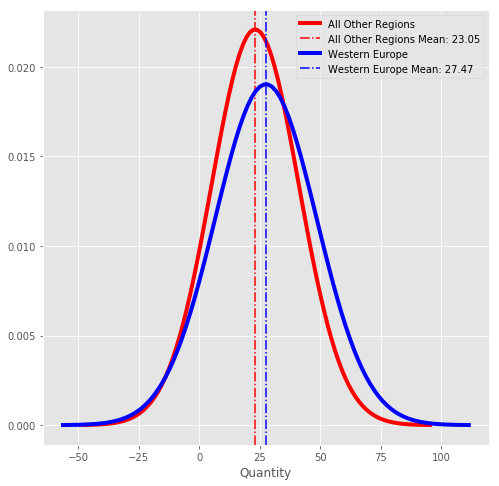

Key Metrics for South America
  All Other Regions Mean: 26.27
  South America Mean: 20.92
  Percent Mean Difference: -20.37%

  All Other Regions Std Dev: 19.24
  South America Std Dev: 14.27
  Percent Std Dev Difference: -25.83%
  Risk Adjusted Return South America: 7.36%

  Test Statistic: -3.6878
  P-Value: 0.000249


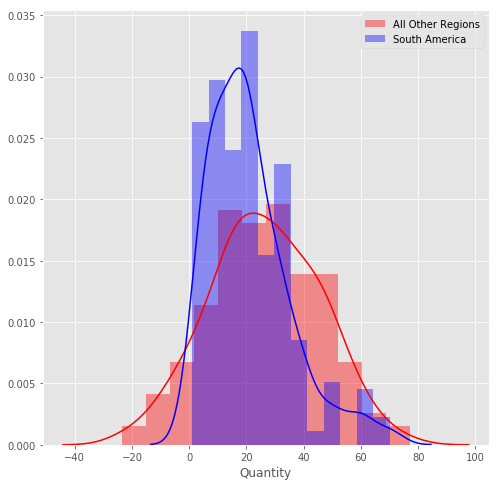

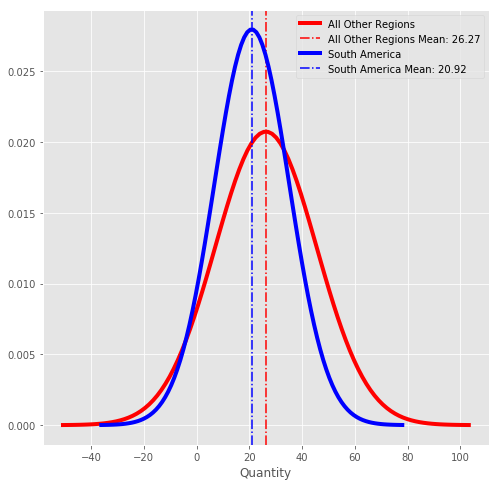

Key Metrics for Central America
  All Other Regions Mean: 26.04
  Central America Mean: 12.11
  Percent Mean Difference: -53.5%

  All Other Regions Std Dev: 18.54
  Central America Std Dev: 7.71
  Percent Std Dev Difference: -58.44%
  Risk Adjusted Return Central America: 11.91%

  Test Statistic: -5.4412
  P-Value: 0.0


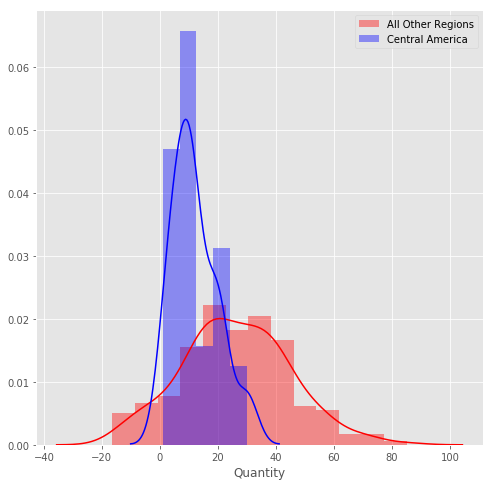

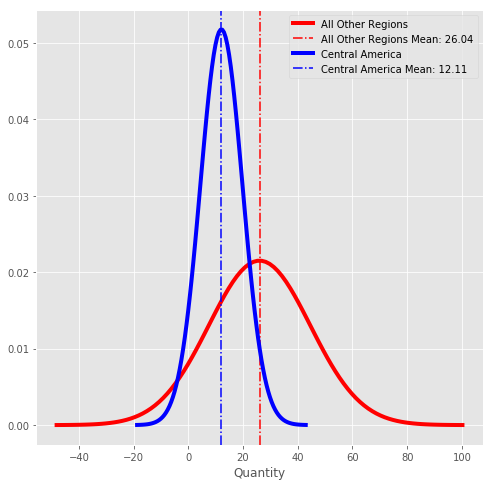

Key Metrics for North America
North America Not Significant at 95.0% Confidence Level

Key Metrics for Northern Europe
Northern Europe Not Significant at 95.0% Confidence Level

Key Metrics for Scandinavia
  All Other Regions Mean: 25.09
  Scandinavia Mean: 14.94
  Percent Mean Difference: -40.43%

  All Other Regions Std Dev: 18.96
  Scandinavia Std Dev: 10.14
  Percent Std Dev Difference: -46.54%
  Risk Adjusted Return Scandinavia: 11.41%

  Test Statistic: -4.2794
  P-Value: 2.5e-05


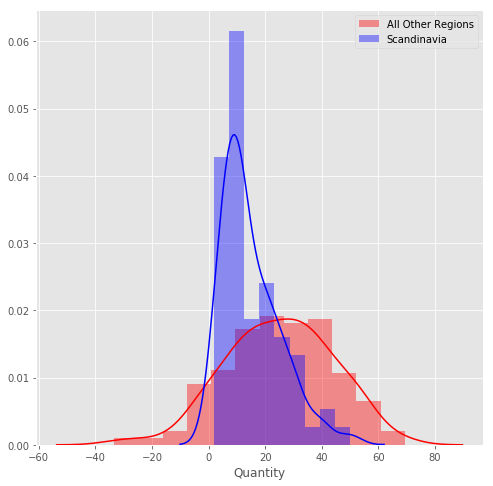

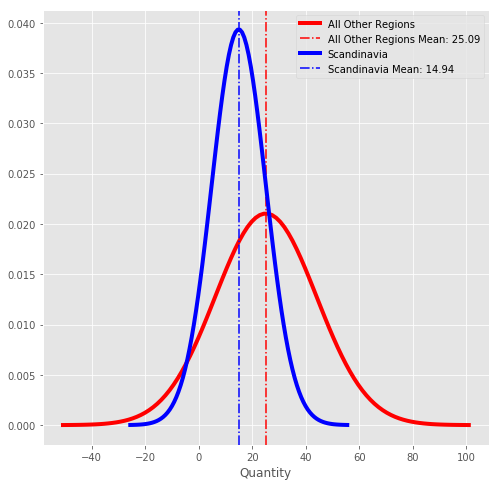

Key Metrics for Southern Europe
  All Other Regions Mean: 24.54
  Southern Europe Mean: 15.13
  Percent Mean Difference: -38.33%

  All Other Regions Std Dev: 21.22
  Southern Europe Std Dev: 11.0
  Percent Std Dev Difference: -48.15%
  Risk Adjusted Return Southern Europe: 18.93%

  Test Statistic: -4.8052
  P-Value: 2e-06


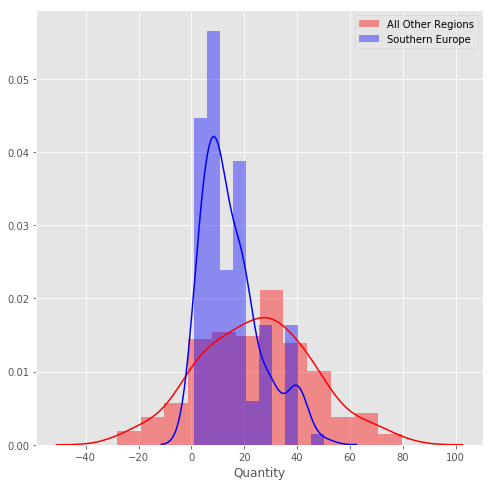

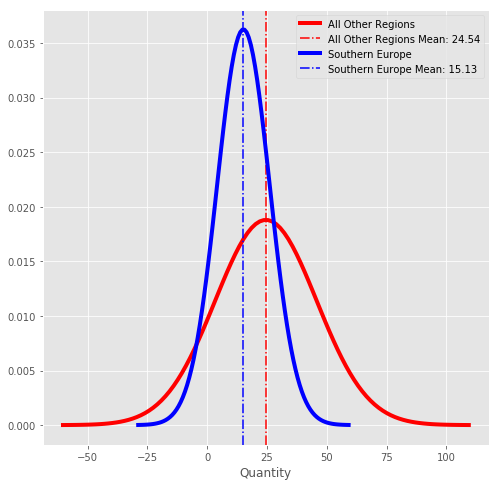

Key Metrics for British Isles
British Isles Not Significant at 95.0% Confidence Level

Key Metrics for Eastern Europe
Eastern Europe Not Significant at 95.0% Confidence Level

Western Europe Results:
  Mean Difference: 19.0%
  Std Dev Difference: 16.1%
  Risk Adjusted Return: 2.65%
  P-Value: 0.004019
-------------------------------------
South America Results:
  Mean Difference: -20.0%
  Std Dev Difference: -25.83%
  Risk Adjusted Return: 7.36%
  P-Value: 0.000249
-------------------------------------
Central America Results:
  Mean Difference: -53.0%
  Std Dev Difference: -58.44%
  Risk Adjusted Return: 11.91%
  P-Value: 0.0
-------------------------------------
Scandinavia Results:
  Mean Difference: -40.0%
  Std Dev Difference: -46.54%
  Risk Adjusted Return: 11.41%
  P-Value: 2.5e-05
-------------------------------------
Southern Europe Results:
  Mean Difference: -38.0%
  Std Dev Difference: -48.15%
  Risk Adjusted Return: 18.93%
  P-Value: 2e-06
---------------------------------

In [17]:
plt.style.use('ggplot')

reg_results = {}
for region in regions:
    test = df['Quantity'].loc[(df['Region'] == region)]

    samp_means, samp_stds = [], []
    for i in range(10000):
        rand_select = np.random.choice(df['Quantity'].loc[(df['Region'] != region)], size=231)
        samp_means.append(np.mean(rand_select))
        samp_stds.append(np.std(rand_select))
        
    control = np.random.normal(np.mean(samp_means), np.mean(samp_stds), 231)
    reg_results[region] = get_results(control, test, ctrl_label='All Other Regions', test_label=region)

for key in reg_results.keys():
    if reg_results[key]['p_val'] < .05:
        print(f'{key} Results:')
        print(f'  Mean Difference: {np.round(100*reg_results[key]["Mean Diff"])}%')
        print(f'  Std Dev Difference: {np.round(100*reg_results[key]["Std Diff"], 2)}%')
        print(f'  Risk Adjusted Return: {np.round(100*reg_results[key]["Risk Adj Rtn"], 2)}%')
        print(f'  P-Value: {np.round(reg_results[key]["p_val"], 6)}')
        print('-------------------------------------')

In Western Europe, customers tend to purchase an additional 18% in quantity of goods than the rest of the world, on average. However, with a standard deviation of 32.4%, the consistency of those returns is much less stable. This implies that other factors may have significantly greater impact on buyer decisions, thus making it a riskier place to do business. Other regions that yield lower returns than the average also have lower standard deviations, making the returns in those regions more consistent and less susceptible to market swings. Though Western Europe may be a good market right now, Northwind would be wise to continue investing in these smaller markets to gain more stability when markets turn south.

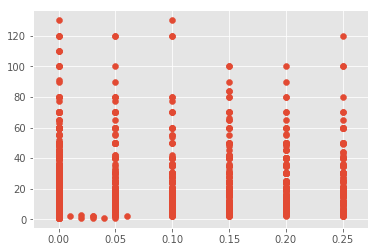

In [18]:
plt.scatter(df['Discount'], df['Quantity'])

In [19]:
# Create bins at 5% intervals
disc_vals = [0, .05, .1, .15, .2, .25]

In [20]:
control = df['Quantity'].loc[df['Discount'] == 0]
control.head()

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

Key Metrics for 5.0% Discount
  No Discount Mean: 21.9
  5.0% Discount Mean: 26.98
  Percent Mean Difference: 23.21%

  No Discount Std Dev: 17.65
  5.0% Discount Std Dev: 22.42
  Percent Std Dev Difference: 27.04%
  Risk Adjusted Return 5.0% Discount: -3.02%

  Test Statistic: 3.5309
  P-Value: 0.000427


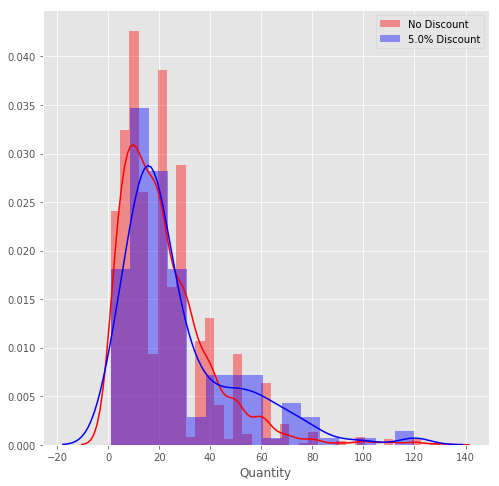

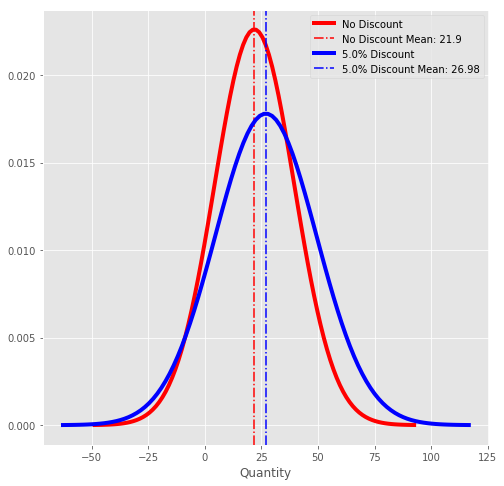

Key Metrics for 10.0% Discount
  No Discount Mean: 21.9
  10.0% Discount Mean: 25.25
  Percent Mean Difference: 15.31%

  No Discount Std Dev: 17.65
  10.0% Discount Std Dev: 21.3
  Percent Std Dev Difference: 20.69%
  Risk Adjusted Return 10.0% Discount: -4.46%

  Test Statistic: 2.2371
  P-Value: 0.025433


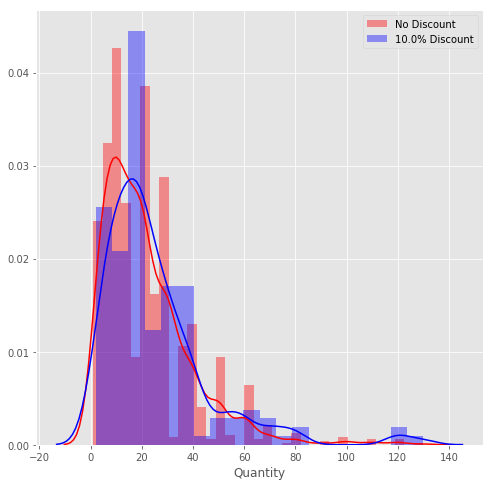

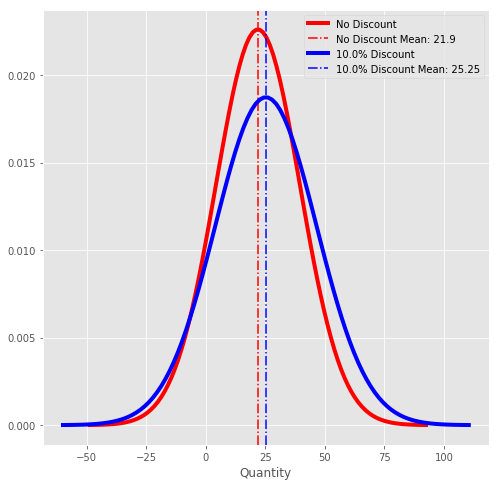

Key Metrics for 15.0% Discount
  No Discount Mean: 21.9
  15.0% Discount Mean: 28.77
  Percent Mean Difference: 31.38%

  No Discount Std Dev: 17.65
  15.0% Discount Std Dev: 21.14
  Percent Std Dev Difference: 19.78%
  Risk Adjusted Return 15.0% Discount: 9.69%

  Test Statistic: 4.4078
  P-Value: 1.1e-05


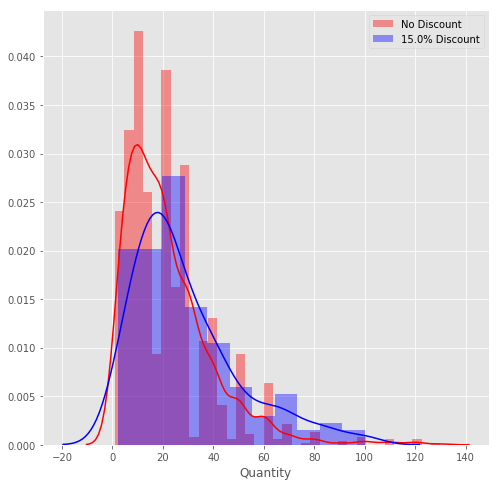

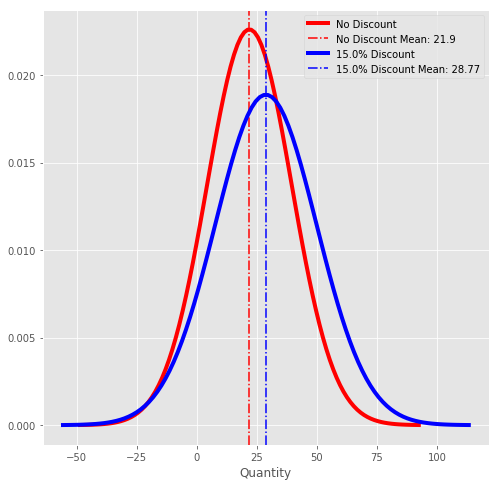

Key Metrics for 20.0% Discount
  No Discount Mean: 21.9
  20.0% Discount Mean: 26.99
  Percent Mean Difference: 23.22%

  No Discount Std Dev: 17.65
  20.0% Discount Std Dev: 18.89
  Percent Std Dev Difference: 7.03%
  Risk Adjusted Return 20.0% Discount: 15.13%

  Test Statistic: 3.3874
  P-Value: 0.000725


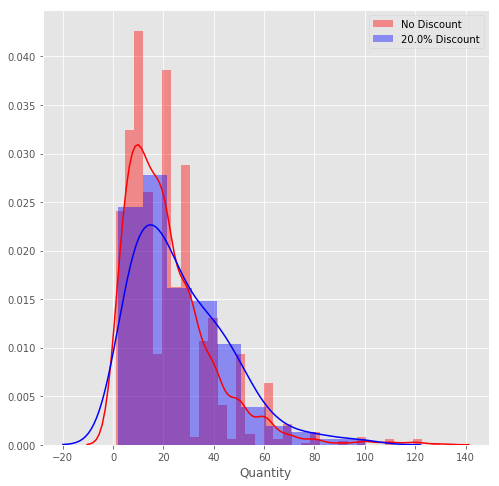

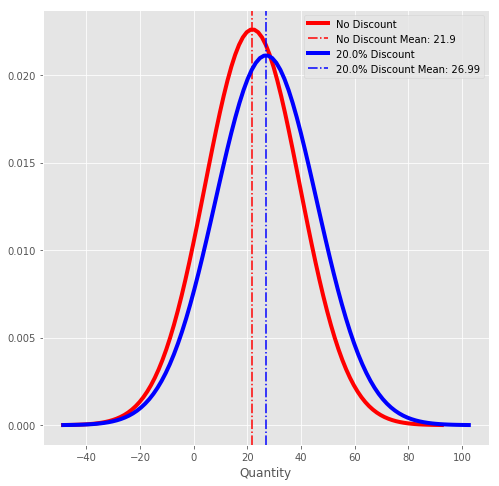

Key Metrics for 25.0% Discount
  No Discount Mean: 21.9
  25.0% Discount Mean: 27.83
  Percent Mean Difference: 27.07%

  No Discount Std Dev: 17.65
  25.0% Discount Std Dev: 20.11
  Percent Std Dev Difference: 13.93%
  Risk Adjusted Return 25.0% Discount: 11.54%

  Test Statistic: 3.7958
  P-Value: 0.000153


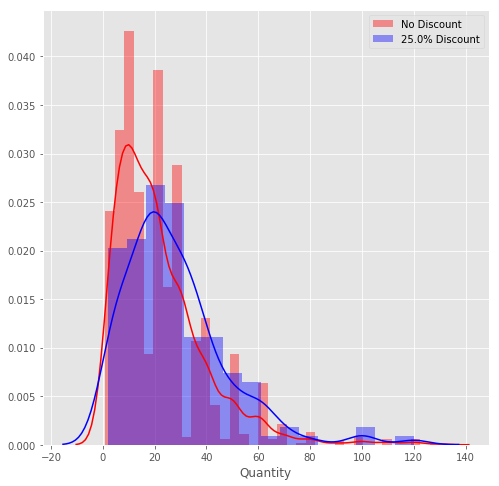

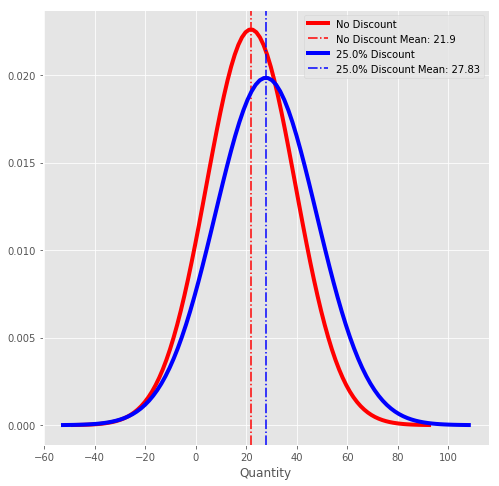

5.0% Discount Results:
  Mean Difference: 23.0%
  Std Dev Difference: 27.04%
  Risk Adjusted Return: -3.02%
  P-Value: 0.000427
-------------------------------------
10.0% Discount Results:
  Mean Difference: 15.0%
  Std Dev Difference: 20.69%
  Risk Adjusted Return: -4.46%
  P-Value: 0.025433
-------------------------------------
15.0% Discount Results:
  Mean Difference: 31.0%
  Std Dev Difference: 19.78%
  Risk Adjusted Return: 9.69%
  P-Value: 1.1e-05
-------------------------------------
20.0% Discount Results:
  Mean Difference: 23.0%
  Std Dev Difference: 7.03%
  Risk Adjusted Return: 15.13%
  P-Value: 0.000725
-------------------------------------
25.0% Discount Results:
  Mean Difference: 27.0%
  Std Dev Difference: 13.93%
  Risk Adjusted Return: 11.54%
  P-Value: 0.000153
-------------------------------------


In [21]:
disc_results = {}
for i in range(len(disc_vals)-1):
    test = df['Quantity'].loc[(df['Discount'] > disc_vals[i]) & (df['Discount'] <= disc_vals[i+1])]
    ctrl_label = 'No Discount'
    test_label = f'{100*disc_vals[i+1]}% Discount'
    disc_results[test_label] = get_results(control, test, ctrl_label=ctrl_label, test_label=test_label)
    
for key in disc_results.keys():
    if disc_results[key]['p_val'] < .05:
        print(f'{key} Results:')
        print(f'  Mean Difference: {np.round(100*disc_results[key]["Mean Diff"])}%')
        print(f'  Std Dev Difference: {np.round(100*disc_results[key]["Std Diff"], 2)}%')
        print(f'  Risk Adjusted Return: {np.round(100*disc_results[key]["Risk Adj Rtn"], 2)}%')
        print(f'  P-Value: {np.round(disc_results[key]["p_val"], 6)}')
        print('-------------------------------------')

In percentage terms, the difference in mean returns at discount levels varies significantly. Using no discount as the control group, we find that the largest mean difference in quantity is at the 15% level. However, as with region, when we look at standard deviation as a measure of risk, we find more consistent, positive results at the 15% discount level and above, with the ideal balance of risk and return existing at the 20% level.

In [22]:
np.mean(df['Employee'].value_counts())

230.88888888888889

Key Metrics for Buchanan5
Buchanan5 Not Significant at 95.0% Confidence Level

Key Metrics for Suyama6
Suyama6 Not Significant at 95.0% Confidence Level

Key Metrics for Peacock4
Peacock4 Not Significant at 95.0% Confidence Level

Key Metrics for Leverling3
Leverling3 Not Significant at 95.0% Confidence Level

Key Metrics for Dodsworth9
Dodsworth9 Not Significant at 95.0% Confidence Level

Key Metrics for Davolio1
Davolio1 Not Significant at 95.0% Confidence Level

Key Metrics for Callahan8
  All Employees Mean: 26.2
  Callahan8 Mean: 22.65
  Percent Mean Difference: -13.55%

  All Employees Std Dev: 20.18
  Callahan8 Std Dev: 17.53
  Percent Std Dev Difference: -13.11%
  Risk Adjusted Return Callahan8: -0.5%

  Test Statistic: -2.0547
  P-Value: 0.040457


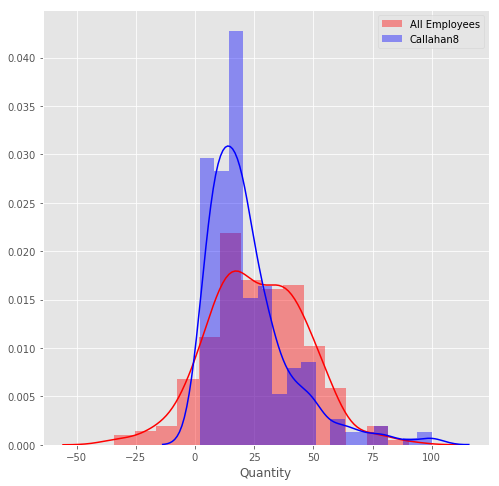

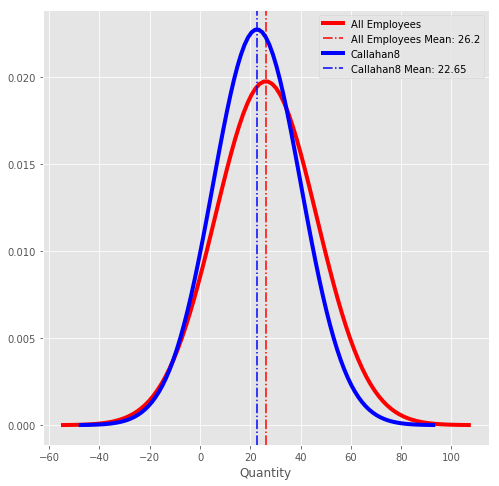

Key Metrics for Fuller2
Fuller2 Not Significant at 95.0% Confidence Level

Key Metrics for King7
King7 Not Significant at 95.0% Confidence Level

Callahan8 Results:
  Mean Difference: -14.0%
  Std Dev Difference: -13.11%
  Risk Adjusted Return: -0.5%
  P-Value: 0.040457
-------------------------------------


In [23]:
emp_results = {}
for emp in df['Employee'].unique():
    test = df['Quantity'].loc[(df['Employee'] == emp)]
    
    # Generate random samples
    samp_means, samp_stds = [], []
    for i in range(10000):
        rand_select = np.random.choice(df['Quantity'].loc[(df['Employee'] != emp)], size=231)
        samp_means.append(np.mean(rand_select))
        samp_stds.append(np.std(rand_select))
        
    control = np.random.normal(np.mean(samp_means), np.mean(samp_stds), 231)
    
    emp_results[emp] = get_results(control, test, ctrl_label='All Employees', test_label=emp)

for key in emp_results.keys():
    if emp_results[key]['p_val'] < .05:
        print(f'{key} Results:')
        print(f'  Mean Difference: {np.round(100*emp_results[key]["Mean Diff"])}%')
        print(f'  Std Dev Difference: {np.round(100*emp_results[key]["Std Diff"], 2)}%')
        print(f'  Risk Adjusted Return: {np.round(100*emp_results[key]["Risk Adj Rtn"], 2)}%')
        print(f'  P-Value: {np.round(emp_results[key]["p_val"], 6)}')
        print('-------------------------------------')

Even though our ANOVA model indicated a statistically significant relationship exists between salesperson and quantity of products sold, it cannot be shown that any single salesperson's performance is consistently, statistically significantly different from group results. If a relationship does exist, it too weak to be worth considering for additional research at this time.

# Conclusions
**Product Category** and **Salesperson** do not have a statistically significant impact on sales volume. <br><br>
**Region** has the largest impact on sales volume, with Western Europe delivering the greatest gains at the expense of consistency. Southern and Eastern Europe, along with Scandanavia and Central America deliver less volume, but they deliver more consistency. It woudl be worth investing resources in those regions in an effort to attain great revenue consistency and bolster against market shifts. <br><br>
**Discounts** also have a statistically significant impact on sales volume, though the volume impact is more consistent at the 15% discount level and above.